# mlrose_ky Generator and Runner Usage Examples - Andrew Rollings
*Modified by Kyle Nakamura*

## Overview

These examples will not solve assignment 2 for you, but they will give you some idea on how to use the problem generator and runner classes.

Hopefully this will result in slightly fewer "How do I \<insert basic usage here\>" questions every semester...

Also, and in case it hasn't been made clear enough by the TAs, using any of the visualizations from this tutorial for your report is a bad idea for two reasons: 
1. It provides nothing useful as far as the assignment goes, and 
2. The TAs will undoubtedly frown upon it.

Visualization is part of the analysis and, for the most part, you're supposed to do that by yourself. Just including
images of the before/after state of a problem really isn't useful in terms of what you're supposed to be analyzing.

## Import Libraries

In [1]:
%pip install chess IPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import HTML

import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string

from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

import mlrose_ky as mlrose
from mlrose_ky.generators import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_ky.runners import SARunner, GARunner, NNGSRunner

# Hide warnings from libraries
logging.basicConfig(level=logging.WARNING)

## Example 1: Solving the 8-Queens problem using the SA algorithm

### Initializing and viewing the problem

First, we'll use the `QueensGenerator` to create an instance of the 8-Queens problem.

In [3]:
# Generate a new 8-Queens optimization problem using a fixed seed
problem = QueensGenerator.generate(seed=123456, size=8)

The initial, un-optimized state can be seen below, both as a list and as a chess board.

Initial state: [2 3 3 2 7 0 1 1]


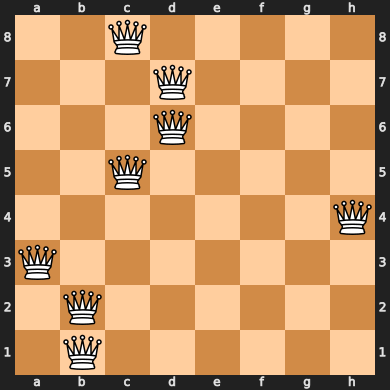

In [4]:
# View the initial state as a list
state = problem.get_state()
print('Initial state:', state)

# View the initial state as a chess board
board_layout = "/".join(["".join(([str(s)] if s > 0 else []) + ["Q"] + ([str((7 - s))] if s < 7 else [])) for s in state])
chess.Board(board_layout)  # You may need to "trust" this notebook for the board visualization to work

### Solving 8-Queens using a Runner (i.e., grid search)

Runners are used to execute "grid search" experiments on optimization problems.

We'll use the Simulated Annealing Runner (SARunner) to perform a grid search on the 8-Queens problem and then extract the optimal SA hyperparameters.

Here is a brief explanation of the SARunner parameters used in the example below:
- `max_attempts`: A list of maximum attempts to try improving the fitness score before terminating a run
- `temperature_list`: A list of temperatures to try when initializing the SA algorithm's decay function (e.g., `GeomDecay(init_temp=1.0)`)
- `decay_list`: A list of decay schedules to try as the SA algorithm's decay function (e.g., `GeomDecay`, `ExpDecay`, etc.)
- `iteration_list`: A list of iterations to snapshot the state of the algorithm at (only determines the rows that the Runner will output)

*Disclaimer: the values used here are just toy values picked specifically for this example. 
You will have to choose your own range of values for your experiments. 
I strongly recommend you don't just copy these, or you will find that the grading is unlikely to go the way you would like.* 

In [5]:
# Create an SA Runner instance to solve the problem
sa = SARunner(
    problem=problem,
    experiment_name="queens_8_sa",
    seed=123456,
    output_directory=None,  # Note: specify an output directory (str) to have these results saved to disk
    max_attempts=100,
    temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
    decay_list=[mlrose.GeomDecay],
    iteration_list=2 ** np.arange(11),  # list of 11 integers from 2^0 to 2^11
)

# Run the SA Runner and retrieve its results
df_run_stats, df_run_curves = sa.run()

In [6]:
# Calculate some simple stats about the experiment
temperatures_per_run = max(1, len(sa.temperature_list))
decays_per_run = max(1, len(sa.decay_list))
iters_per_run = len(sa.iteration_list) + 1
total_runs = temperatures_per_run * decays_per_run

print(f"The experiment executed {total_runs} runs, each with {iters_per_run} snapshots at different iterations.")
print(f"In total, the output dataframe should contain {total_runs * iters_per_run} rows.")

The experiment executed 6 runs, each with 12 snapshots at different iterations.
In total, the output dataframe should contain 72 rows.


The `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations specified in the `iteration_list`.

Since `iterations_list` contains 11 numbers, and iteration 0 is always included in the results, each run will take up 12 rows of the dataframe.

The first 12 rows (i.e., results from the first run) are shown below:

In [7]:
HTML(df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][:iters_per_run].to_html(index=False))

Iteration,Fitness,FEvals,Time,State
0,11.0,0,0.000952,"[1, 2, 2, 1, 0, 3, 7, 3]"
1,9.0,2,0.002065,"[1, 2, 2, 0, 0, 3, 7, 3]"
2,8.0,4,0.002482,"[1, 2, 2, 0, 0, 3, 7, 5]"
4,8.0,7,0.002940,"[1, 2, 2, 5, 0, 3, 7, 5]"
8,5.0,13,0.003546,"[1, 2, 7, 5, 0, 3, 5, 5]"
16,4.0,24,0.004385,"[1, 2, 7, 5, 3, 0, 5, 5]"
32,4.0,47,0.005881,"[1, 5, 7, 5, 0, 0, 3, 4]"
64,1.0,86,0.008455,"[1, 5, 2, 6, 3, 0, 7, 4]"
128,1.0,155,0.013444,"[1, 5, 2, 6, 3, 0, 4, 7]"
256,1.0,295,0.024719,"[1, 7, 2, 6, 3, 5, 0, 4]"


Some information was intentionally excluded from the previous output. Let's now preview the entirety of the first run:

In [8]:
HTML(df_run_stats[:iters_per_run].to_html())

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
0,0,11.0,0,0.000952,"[1, 2, 2, 1, 0, 3, 7, 3]",geometric,0.1,0.99,0.001,0.099999,0.1,1024
1,1,9.0,2,0.002065,"[1, 2, 2, 0, 0, 3, 7, 3]",geometric,0.1,0.99,0.001,0.099998,0.1,1024
2,2,8.0,4,0.002482,"[1, 2, 2, 0, 0, 3, 7, 5]",geometric,0.1,0.99,0.001,0.099998,0.1,1024
3,4,8.0,7,0.002940,"[1, 2, 2, 5, 0, 3, 7, 5]",geometric,0.1,0.99,0.001,0.099997,0.1,1024
4,8,5.0,13,0.003546,"[1, 2, 7, 5, 0, 3, 5, 5]",geometric,0.1,0.99,0.001,0.099996,0.1,1024
5,16,4.0,24,0.004385,"[1, 2, 7, 5, 3, 0, 5, 5]",geometric,0.1,0.99,0.001,0.099996,0.1,1024
6,32,4.0,47,0.005881,"[1, 5, 7, 5, 0, 0, 3, 4]",geometric,0.1,0.99,0.001,0.099994,0.1,1024
7,64,1.0,86,0.008455,"[1, 5, 2, 6, 3, 0, 7, 4]",geometric,0.1,0.99,0.001,0.099992,0.1,1024
8,128,1.0,155,0.013444,"[1, 5, 2, 6, 3, 0, 4, 7]",geometric,0.1,0.99,0.001,0.099986,0.1,1024
9,256,1.0,295,0.024719,"[1, 7, 2, 6, 3, 5, 0, 4]",geometric,0.1,0.99,0.001,0.099975,0.1,1024


**What does all this information tell us about the first run of our experiment?**

1. `Iteration` shows the index of the snapshot, with 12 snapshots per run in this example.
2. `Fitness` shows the fitness score of the state at the corresponding iteration, where 0.0 is optimal for minimization problems.
3. `FEvals` shows the number of fitness function evaluations performed by the algorithm at the corresponding iteration.
4. `Time` shows the time elapsed (calculated using `time.perf_counter()`) up to the corresponding iteration.
5. `State` shows the state of the algorithm at the corresponding iteration (see `mlrose_ky.fitness.queens` for more details).
6. `Temperature` shows the decay function (and its parameters) that was used for this run. We will have 6 unique values in this column, one for each run.
7. `max_iters` shows the maximum number of iterations allowed for the algorithm to run. It defaults to `max(iteration_list)` for all Runners, which is 1024 in this case.

To pick out the most performant run from the dataframe, we need to find the row with the best fitness.
Since Queens is a minimization problem, we're looking for the row with minimal fitness (i.e., zero).

It's likely that multiple runs will achieve the same fitness, so we need to find the run that achieved the best `Fitness` in the fewest `FEvals` (*Note: we could make this selection using `Iterations` or `Time` if we so desired.*)

In [9]:
best_fitness = df_run_stats["Fitness"].min()  # Should be 0.0 in this case

# Get all runs with the best fitness value
best_runs = df_run_stats[df_run_stats["Fitness"] == best_fitness]
HTML(best_runs.to_html())

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
10,512,0.0,461,0.041867,"[1, 5, 0, 6, 3, 7, 2, 4]",geometric,0.1,0.99,0.001,0.099958,0.1,1024
11,1024,0.0,461,0.041867,"[1, 5, 0, 6, 3, 7, 2, 4]",geometric,0.1,0.99,0.001,0.099958,0.1,1024
22,512,0.0,461,0.041341,"[1, 5, 0, 6, 3, 7, 2, 4]",geometric,0.5,0.99,0.001,0.499792,0.5,1024
23,1024,0.0,461,0.041341,"[1, 5, 0, 6, 3, 7, 2, 4]",geometric,0.5,0.99,0.001,0.499792,0.5,1024
58,512,0.0,427,0.041364,"[7, 1, 3, 0, 6, 4, 2, 5]",geometric,2.0,0.99,0.001,1.999169,2.0,1024
59,1024,0.0,427,0.041364,"[7, 1, 3, 0, 6, 4, 2, 5]",geometric,2.0,0.99,0.001,1.999169,2.0,1024
70,512,0.0,583,0.057543,"[6, 0, 2, 7, 5, 3, 1, 4]",geometric,5.0,0.99,0.001,4.997109,5.0,1024
71,1024,0.0,583,0.057543,"[6, 0, 2, 7, 5, 3, 1, 4]",geometric,5.0,0.99,0.001,4.997109,5.0,1024


This gives us our candidates for the best run. 

The best run will be the one that achieved the best fitness in the fewest evaluations.

In [10]:
minimum_evaluations = best_runs["FEvals"].min()  # Should be 461 in this case

# Extract the best run with the minimum number of evaluations
best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best run using these criteria is as follows:

In [11]:
HTML(best_run.to_html())

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
58,512,0.0,427,0.041364,"[7, 1, 3, 0, 6, 4, 2, 5]",geometric,2.0,0.99,0.001,1.999169,2.0,1024
59,1024,0.0,427,0.041364,"[7, 1, 3, 0, 6, 4, 2, 5]",geometric,2.0,0.99,0.001,1.999169,2.0,1024


Which has the following identifying state information:

In [12]:
best_temperature_param = best_run["Temperature"].iloc[0].init_temp
best_temperature_param

2.0

To map this result back to the original output of the Runner, we are looking for all rows in `df_run_stats` where the temperature is equal to 2.

In [13]:
run_stats_best_run = df_run_stats[df_run_stats["schedule_init_temp"] == best_temperature_param]
HTML(run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time", "State"]].to_html())

,Iteration,Fitness,FEvals,Time,State
48,0,11.0,0,0.000125,"[1, 2, 2, 1, 0, 3, 7, 3]"
49,1,9.0,2,0.001411,"[1, 2, 2, 0, 0, 3, 7, 3]"
50,2,8.0,4,0.002682,"[1, 2, 2, 0, 0, 3, 7, 5]"
51,4,8.0,7,0.003995,"[1, 2, 2, 5, 0, 3, 7, 5]"
52,8,7.0,14,0.005628,"[1, 2, 2, 5, 0, 3, 5, 5]"
53,16,6.0,27,0.007493,"[3, 2, 3, 5, 0, 1, 5, 5]"
54,32,4.0,57,0.010227,"[3, 5, 6, 5, 5, 0, 4, 7]"
55,64,5.0,114,0.014508,"[2, 0, 3, 6, 1, 2, 1, 7]"
56,128,3.0,205,0.021204,"[2, 0, 6, 3, 5, 0, 4, 3]"
57,256,2.0,358,0.033639,"[7, 1, 3, 6, 6, 4, 0, 5]"


And the best state associated with this is:

In [14]:
best_state = run_stats_best_run[["schedule_current_value", "schedule_init_temp", "schedule_min_temp"]].tail(1)
HTML(best_state.to_html())

,schedule_current_value,schedule_init_temp,schedule_min_temp
59,1.999169,2.0,0.001


The final state is as follows:

[7, 1, 3, 0, 6, 4, 2, 5]


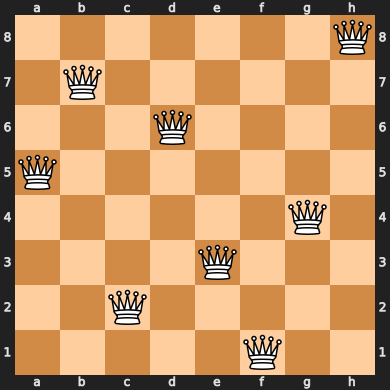

In [15]:
state = literal_eval(run_stats_best_run["State"].tail(1).values[0])
print(state)
board_layout = "/".join(["".join(([str(s)] if s > 0 else []) + ["Q"] + ([str((7 - s))] if s < 7 else [])) for s in state])
board = chess.Board(board_layout)
board

### Example 2: Generating and Running Max K Color using the GA algorithm

In [16]:
# Generate a new Max K problem using a fixed seed.
problem = MaxKColorGenerator().generate(seed=123456, number_of_nodes=10, max_connections_per_node=3, max_colors=3)

The input graph generated for the problem looks like this:

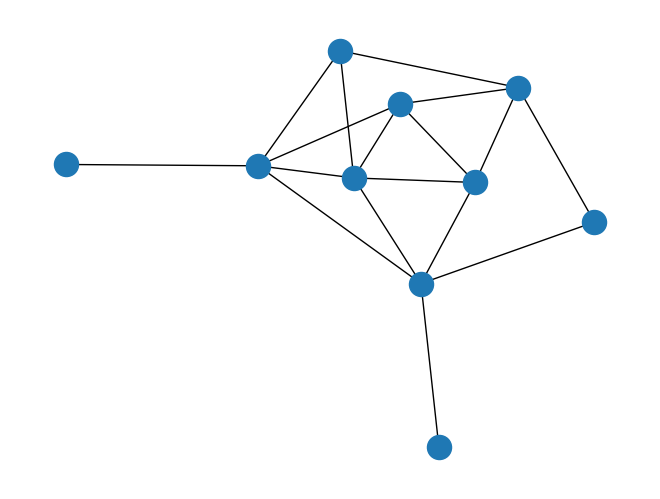

In [17]:
nx.draw(problem.source_graph, pos=nx.spring_layout(problem.source_graph, seed=3))
plt.show()

In [18]:
# create a runner class and solve the problem
ga = GARunner(
    problem=problem,
    experiment_name="max_k_ga",
    output_directory=None,  # note: specify an output directory to have results saved to disk
    seed=123456,
    iteration_list=2 ** np.arange(11),
    population_sizes=[10, 20, 50],
    mutation_rates=[0.1, 0.2, 0.5],
)

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [19]:
HTML(df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,3.0,10,0.00037,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2]"


The state information is excluded from the previous output.

A sample of this is below:

In [20]:
state_sample = df_run_stats[["Population Size", "Mutation Rate"]][:1]
HTML(state_sample.to_html())

,Population Size,Mutation Rate
0,10,0.1


So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As Max-K-Color is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [21]:
best_fitness = df_run_curves["Fitness"].min()
best_runs = df_run_curves[df_run_curves["Fitness"] == best_fitness]

HTML(best_runs.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
4,4,0.005363,0.0,57.0,10,0.1,1024
9,4,0.005363,0.0,57.0,10,0.2,1024
18,8,0.001469,0.0,101.0,10,0.5,1024
24,5,0.000098,0.0,127.0,20,0.1,1024
27,2,0.003955,0.0,64.0,20,0.2,1024
31,3,0.005179,0.0,85.0,20,0.5,1024
41,9,0.001640,0.0,511.0,50,0.1,1024
45,3,0.005179,0.0,205.0,50,0.2,1024
50,4,0.005363,0.0,256.0,50,0.5,1024


This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [22]:
minimum_evaluations = best_runs["FEvals"].min()

best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best runs using these criteria is as follows:

In [23]:
HTML(best_run.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
4,4,0.005363,0.0,57.0,10,0.1,1024
9,4,0.005363,0.0,57.0,10,0.2,1024


We will arbitrarily pick the first row for this example,
which has the following identifying state information:

In [24]:
best_mr = best_run["Mutation Rate"].iloc()[0]
best_pop_size = best_run["Population Size"].iloc()[0]
print(f"Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}")

Best Mutation Rate: 0.1, best Population Size: 10


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [25]:
run_stats_best_run = df_run_stats[(df_run_stats["Mutation Rate"] == best_mr) & (df_run_stats["Population Size"] == best_pop_size)]
HTML(run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time"]].to_html())

,Iteration,Fitness,FEvals,Time
0,0,3.0,10,0.000370
1,1,3.0,21,0.002672
2,2,2.0,33,0.003955
3,4,0.0,57,0.005363
4,8,0.0,57,0.005363
5,16,0.0,57,0.005363
6,32,0.0,57,0.005363
7,64,0.0,57,0.005363
8,128,0.0,57,0.005363
9,256,0.0,57,0.005363


And the best state associated with this is:

In [26]:
best_state = run_stats_best_run[["State"]].tail(1)
HTML(best_state.to_html())

,State
11,"[0, 1, 2, 0, 0, 2, 0, 1, 2, 1]"


For the following node ordering:

In [27]:
print([n for n in problem.source_graph.nodes])

[0, 2, 8, 1, 3, 4, 6, 7, 9, 5]


Reordering the state by ascending node number gives the following:

In [28]:
color_indexes = literal_eval(run_stats_best_run["State"].tail(1).values[0])
ordered_state = [color_indexes[n] for n in problem.source_graph.nodes]
print(ordered_state)

[0, 2, 2, 1, 0, 0, 0, 1, 1, 2]


Which results in a graph looking like this:

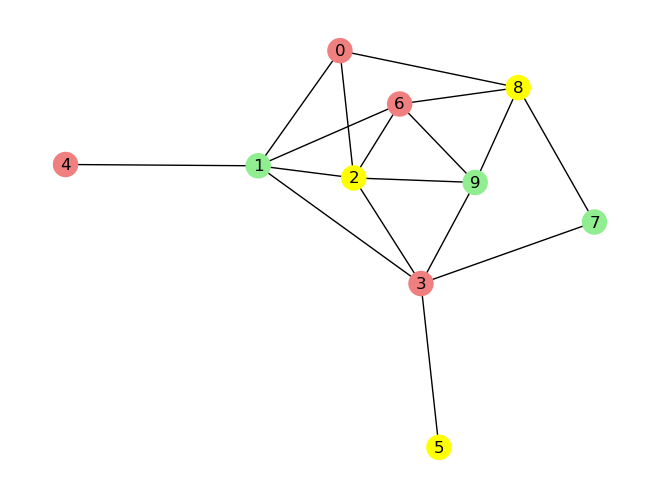

In [29]:
colors = ["lightcoral", "lightgreen", "yellow"]
node_color_map = [colors[s] for s in ordered_state]

nx.draw(problem.source_graph, pos=nx.spring_layout(problem.source_graph, seed=3), with_labels=True, node_color=node_color_map)
plt.show()

### Example 3: Generating and Running TSP using the GA algorithm

In [30]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=20)

The input graph generated for the problem looks like this:

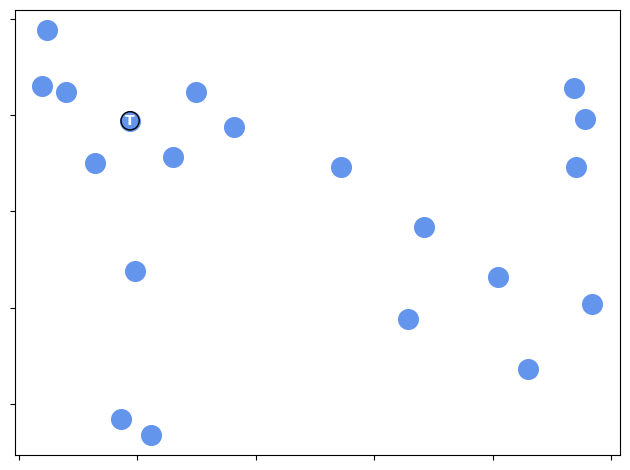

In [31]:
fig, ax = plt.subplots(1)  # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x, y) in enumerate(problem.coords):
    ax.scatter(x, y, s=200, c="cornflowerblue")  # plot A
node_labels = {k: str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x, y = problem.coords[i]
plt.text(
    x,
    y,
    node_labels[i],
    ha="center",
    va="center",
    c="white",
    fontweight="bold",
    bbox=dict(boxstyle=f"circle,pad=0.15", fc="cornflowerblue"),
)

plt.tight_layout()
plt.show()

In [32]:
# create a runner class and solve the problem
ga = GARunner(
    problem=problem,
    experiment_name="tsp_ga",
    output_directory=None,  # note: specify an output directory to have results saved to disk
    seed=123456,
    iteration_list=2 ** np.arange(11),
    population_sizes=[10, 20],
    mutation_rates=[0.1, 0.25, 0.5],
)

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [33]:
HTML(df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,2722.031402,10,0.000525,"[19, 13, 12, 9, 5, 6, 2, 3, 18, 8, 4, 7, 0, 14, 16, 15, 11, 17, 10, 1]"


The state information is excluded from the previous output.

A sample of this is below:

In [34]:
state_sample = df_run_stats[["Population Size", "Mutation Rate"]][:1]
HTML(state_sample.to_html())

,Population Size,Mutation Rate
0,10,0.1


So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As TSP is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [35]:
best_fitness = df_run_curves["Fitness"].min()
best_runs = df_run_curves[df_run_curves["Fitness"] == best_fitness]

HTML(best_runs[0:10].to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
3709,707,0.298996,941.582778,14903.0,20,0.1,1024
3710,708,0.299433,941.582778,14924.0,20,0.1,1024
3711,709,0.299878,941.582778,14945.0,20,0.1,1024
3712,710,0.300326,941.582778,14966.0,20,0.1,1024
3713,711,0.300763,941.582778,14987.0,20,0.1,1024
3714,712,0.301215,941.582778,15008.0,20,0.1,1024
3715,713,0.301681,941.582778,15029.0,20,0.1,1024
3716,714,0.302119,941.582778,15050.0,20,0.1,1024
3717,715,0.302555,941.582778,15071.0,20,0.1,1024
3718,716,0.302984,941.582778,15092.0,20,0.1,1024


This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [36]:
minimum_evaluations = best_runs["FEvals"].min()

best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best runs using these criteria is as follows:

In [37]:
HTML(best_run.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
3709,707,0.298996,941.582778,14903.0,20,0.1,1024


This has the following identifying state information:

In [38]:
best_mr = best_run["Mutation Rate"].iloc()[0]
best_pop_size = best_run["Population Size"].iloc()[0]
print(f"Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}")

Best Mutation Rate: 0.1, best Population Size: 20


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [39]:
run_stats_best_run = df_run_stats[(df_run_stats["Mutation Rate"] == best_mr) & (df_run_stats["Population Size"] == best_pop_size)]
HTML(run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time"]].to_html())

,Iteration,Fitness,FEvals,Time
36,0,2722.031402,20,0.000248
37,1,2141.868537,42,0.002722
38,2,2141.868537,63,0.005131
39,4,2141.868537,105,0.008229
40,8,2044.319536,190,0.012927
41,16,1807.055513,360,0.020693
42,32,1785.714484,697,0.034313
43,64,1479.922718,1376,0.059661
44,128,1151.614761,2731,0.108593
45,256,1081.456468,5421,0.205270


And the best state associated with this is:

In [40]:
best_state = run_stats_best_run[["State"]].tail(1)
HTML(best_state.to_html())

,State
47,"[9, 0, 19, 17, 14, 15, 16, 8, 12, 5, 1, 6, 18, 2, 10, 13, 11, 4, 7, 3]"


Which results in a graph looking like this:

In [41]:
ordered_state = literal_eval(run_stats_best_run["State"].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i + 1) % len(ordered_state)]): f"{str(i + 1)}➜" for i in range(len(ordered_state))}
# print(ordered_state)

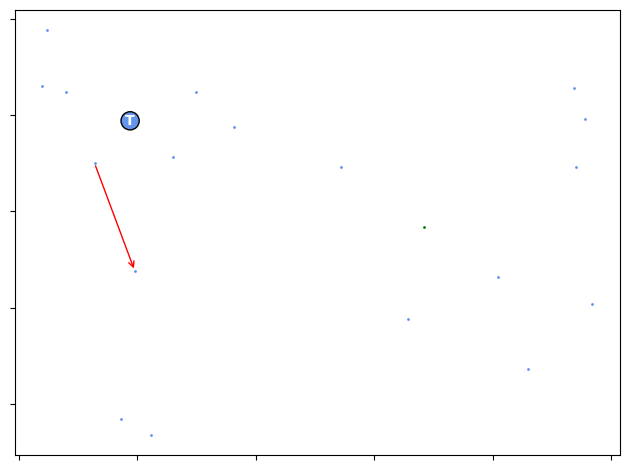

In [42]:
fig, ax = plt.subplots(1)  # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x, y) in enumerate(problem.coords):
    ax.scatter(x, y, s=1, c="green" if i == 5 else "cornflowerblue")  # plot A

for i in range(len(ordered_state)):
    start_node = ordered_state[i]
end_node = ordered_state[(i + 1) % len(ordered_state)]
start_pos = problem.coords[start_node]
end_pos = problem.coords[end_node]
ax.annotate(
    "",
    xy=start_pos,
    xycoords="data",
    xytext=end_pos,
    textcoords="data",
    c="red",
    arrowprops=dict(arrowstyle="->", ec="red", connectionstyle="arc3"),
)
node_labels = {k: str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x, y = problem.coords[i]
plt.text(
    x,
    y,
    node_labels[i],
    ha="center",
    va="center",
    c="white",
    fontweight="bold",
    bbox=dict(boxstyle=f"circle,pad=0.15", fc="green" if i == ordered_state[0] else "cornflowerblue"),
)

plt.tight_layout()
plt.show()

And, to verify that the route is correct (or at least, the shortest one found):

In [43]:
all_edge_lengths = {(x, y): d for x, y, d in problem.distances}
all_edge_lengths.update({(y, x): d for x, y, d in problem.distances})

route_length = sum([all_edge_lengths[k] for k in edge_labels.keys()])
print(f"route_length: ({round(route_length, 6)}) equal to best_fitness: ({round(best_fitness, 6)})")

route_length: (941.582778) equal to best_fitness: (941.582778)


### Example 4: Using the NNGSRunner with the RHC algorithm

In [44]:
# Load and Split data into training and test sets
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=123456)

# Normalize feature data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

grid_search_parameters = {
    "max_iters": [1000],  # nn params
    "learning_rate": [1e-2],  # nn params
    "activation": [mlrose.relu],  # nn params
    "restarts": [1],  # rhc params
}

nnr = NNGSRunner(
    x_train=X_train_scaled,
    y_train=y_train_hot,
    x_test=X_test_scaled,
    y_test=y_test_hot,
    experiment_name="nn_test_rhc",
    algorithm=mlrose.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None,
)

run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ERROR:root:An error occurred while predicting: Found input variables with inconsistent numbers of samples: [105, 45]


The runner returns the `run_stats` and `curves` corresponding to *best* hyperparameter combination,
as well as the cross validation results and the underlying `GridSearchCV` object used in the run.

In [45]:
y_test_pred = grid_search_cv.predict(X_test_scaled)
y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
print(y_test_accuracy)

TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [ ]:
y_train_pred = grid_search_cv.predict(X_train_scaled)
y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
print(y_train_accuracy)

In [ ]:
HTML(run_stats_df[["current_restart", "Iteration", "Fitness", "FEvals", "Time", "learning_rate"]][0:14].to_html())

In [ ]:
HTML(curves_df[["current_restart", "Iteration", "Fitness", "FEvals", "Time", "learning_rate"]][0:20].to_html())

In [ ]:
HTML(
    cv_results_df[
        [
            "mean_test_score",
            "rank_test_score",
            "mean_train_score",
            "param_activation",
            "param_hidden_layer_sizes",
            "param_learning_rate",
            "param_max_iters",
            "param_restarts",
        ]
    ].to_html()
)